In [1]:
import torch
import torch.distributed as dist
import sys
import torch
from sklearn.metrics import roc_auc_score
from torch import nn
from tqdm import tqdm

class ConfusionMatrix:
    def __init__(self, num_classes,device):
        self.num_classes = num_classes
        self.mat = torch.zeros((num_classes, num_classes), dtype=torch.int64,device=device)

    def update(self, a, b):
        n = self.num_classes
        with torch.no_grad():
            mask = (a >= 0) & (a < n)
            a = a[mask].to(torch.int64)
            b = b[mask].to(torch.int64)
            indices = n * a + b
            counts = torch.bincount(indices, minlength=n ** 2)
            self.mat += counts.reshape(n, n)

    def reset(self):
        self.mat.zero_()

    def compute(self):
        h = self.mat.float()
        diag_sum = torch.diag(h).sum()
        total_sum = h.sum()
        acc_global = (diag_sum / total_sum).item() if total_sum > 0 else 0.0
        se = (h[1, 1] / h[1].sum()).item() if h[1].sum() > 0 else 0.0
        sp = (h[0, 0] / h[0].sum()).item() if h[0].sum() > 0 else 0.0
        pr = (h[1, 1] / h[:, 1].sum()).item() if h[:, 1].sum() > 0 else 0.0
        F1 = 2 * (pr * se) / (pr + se) if (pr + se) > 0 else 0.0
        return acc_global, se, sp, F1, pr

def evaluate(model, data_loader, num_classes):
    model.eval()
    confmat = ConfusionMatrix(num_classes,device="cuda")
    data_loader = tqdm(data_loader)
    mask = None
    predict = None
    dice_c = 0

    with torch.no_grad():
        for data in data_loader:
            for image, target, eye_masks in data:
                image, target = image.cuda(), target.cuda()
                output = model(image)
                if type(output) is list:
                    output = output[0]
                output = torch.sigmoid(output)
                truth = output.clone()
                output[output >= 0.5] = 1
                output[output < 0.5] = 0
                confmat.update(target.flatten(), output.long().flatten())
                dice_c += dice_coeff(output, target)
                mask = target.flatten() if mask is None else torch.cat((mask, target.flatten()))
                predict = truth.flatten() if predict is None else torch.cat((predict, truth.flatten()))

    mask = mask.cpu().numpy()
    predict = predict.cpu().numpy()
    AUC_ROC = roc_auc_score(mask, predict)
    iou = calculate_iou(model,data_loader)
    return confmat.compute()[0], confmat.compute()[1], confmat.compute()[2], confmat.compute()[3], confmat.compute()[
        4], AUC_ROC, dice_c / len(data_loader), iou

    
def dice_coeff(x: torch.Tensor, target: torch.Tensor, epsilon=1e-6):
    d = 0.
    batch_size = x.shape[0]
    for i in range(batch_size):
        x_i = x[i].reshape(-1)
        t_i = target[i].reshape(-1).float()
        inter = torch.dot(x_i, t_i)
        sets_sum = torch.sum(x_i) + torch.sum(t_i)
        if sets_sum == 0:
            sets_sum = 2 * inter
        d += (2 * inter + epsilon) / (sets_sum + epsilon)
    return d / batch_size
    
def calculate_iou(model, dataloader):
    model.eval()
    total_iou = 0.0
    num_batches = len(dataloader)
    with torch.no_grad():
        for data in dataloader:
            z = len(data)
            for images, masks, eye_masks in data:
                images = images.to(device)
                masks = masks.to(device)
                outputs = model(images)
                
                # Convert outputs to binary predictions
                binary_preds = (outputs > 0.5).float()
                
                # Calculate intersection and union
                intersection = torch.logical_and(binary_preds, masks).sum((1, 2))  # Sum over height and width
                union = torch.logical_or(binary_preds, masks).sum((1, 2))         # Sum over height and width
                
                # Calculate IOU for each sample in the batch
                iou_per_sample = torch.where(union == 0, torch.ones_like(union), intersection.float() / union.float())
                
                # Average IOU across the batch
                batch_iou = iou_per_sample.mean().item()
                total_iou += batch_iou
    
    # Calculate average IOU across all batches
    avg_iou = total_iou / (num_batches*z)
    return avg_iou


In [2]:
import torch.nn.functional as F
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import v2
from PIL import Image
import torchsummary
import torch.optim as optim
import numpy as np
import torchvision.utils
# from train_utils.train_and_eval import train_one_epoch, evaluate, create_lr_scheduler

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)

    return inp
    
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None,windows_size=(128,128),stride=(32,32)):
        self.root_dir = root_dir
        self.transform = transform
        self.window_size = windows_size
        self.stride = stride
        
        self.image_dir = os.path.join(root_dir,'images')
        self.mask_dir = os.path.join(root_dir,'1st_manual')
        self.eye_mask_dir = os.path.join(root_dir,'mask')
        
        self.image_filenames = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_name = self.image_filenames[idx]
        image_path = os.path.join(self.image_dir,image_name)
        image = Image.open(image_path).convert('L')
        patches_image = self.extract_patches(image)
        
        mask_name = image_name.replace("training.tif","manual1.gif")
        mask_path = os.path.join(self.mask_dir,mask_name)
        mask = Image.open(mask_path).convert('L')
        patches_mask = self.extract_patches(mask)
        

        eye_mask_name = image_name.replace(".tif","_mask.gif")
        eye_mask_path = os.path.join(self.eye_mask_dir,eye_mask_name)
        eye_mask = Image.open(eye_mask_path).convert('L')
        patches_eye_mask = self.extract_patches(eye_mask)

        data = []
        if self.transform:
            for patch1,patch2,patch3 in zip(patches_image,patches_mask,patches_eye_mask):
                data.append((self.transform(patch1),self.transform(patch2),self.transform(patch3)))

        return data

    def extract_patches(self, image):
        patches = []
        width, height = image.size
        window_height, window_width = self.window_size
        stride_vertical, stride_horizontal = self.stride

        for y in range(0, height - window_height + 1, stride_vertical):
            for x in range(0, width - window_width + 1, stride_horizontal):
                patch = image.crop((x, y, x + window_width, y + window_height))
                patches.append(patch)

        return patches

transform = v2.Compose([
    # v2.Resize((224,224)),
    # v2.RandomRotation(degrees=(0,180)),
    v2.Compose([v2.ToImage(),v2.ToDtype(torch.float32,scale=True)]),
    # v2.Normalize([0.485], [0.229]),
])

In [3]:
train_dataset = CustomDataset(root_dir="./training",transform=transform)
val_dataset = CustomDataset(root_dir="./validation",transform=transform)

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=False)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=False)

In [4]:
class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class Recurrent_block(nn.Module):
    def __init__(self,ch_out,t=2):
        super(Recurrent_block,self).__init__()
        self.t = t
        self.ch_out = ch_out
        self.conv = nn.Sequential(
            nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
		    nn.BatchNorm2d(ch_out),
			nn.ReLU(inplace=True)
        )

    def forward(self,x):
        for i in range(self.t):

            if i==0:
                x1 = self.conv(x)
            
            x1 = self.conv(x+x1)
        return x1

class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi

class RRCNN_block(nn.Module):
    def __init__(self,ch_in,ch_out,t=2):
        super(RRCNN_block,self).__init__()
        self.RCNN = nn.Sequential(
            Recurrent_block(ch_out,t=t),
            Recurrent_block(ch_out,t=t)
        )
        self.Conv_1x1 = nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)

    def forward(self,x):
        x = self.Conv_1x1(x)
        x1 = self.RCNN(x)
        return x+x1


class R2AttU_Net(nn.Module):
    def __init__(self,img_ch=1,output_ch=1,t=2):
        super(R2AttU_Net,self).__init__()
        
        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.Upsample = nn.Upsample(scale_factor=2)

        self.RRCNN1 = RRCNN_block(ch_in=img_ch,ch_out=64,t=t)

        self.RRCNN2 = RRCNN_block(ch_in=64,ch_out=128,t=t)
        
        self.RRCNN3 = RRCNN_block(ch_in=128,ch_out=256,t=t)
        
        self.RRCNN4 = RRCNN_block(ch_in=256,ch_out=512,t=t)
        
        self.RRCNN5 = RRCNN_block(ch_in=512,ch_out=1024,t=t)
        

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Att5 = Attention_block(F_g=512,F_l=512,F_int=256)
        self.Up_RRCNN5 = RRCNN_block(ch_in=1024, ch_out=512,t=t)
        
        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Att4 = Attention_block(F_g=256,F_l=256,F_int=128)
        self.Up_RRCNN4 = RRCNN_block(ch_in=512, ch_out=256,t=t)
        
        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Att3 = Attention_block(F_g=128,F_l=128,F_int=64)
        self.Up_RRCNN3 = RRCNN_block(ch_in=256, ch_out=128,t=t)
        
        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Att2 = Attention_block(F_g=64,F_l=64,F_int=32)
        self.Up_RRCNN2 = RRCNN_block(ch_in=128, ch_out=64,t=t)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.RRCNN1(x)

        x2 = self.Maxpool(x1)
        x2 = self.RRCNN2(x2)
        
        x3 = self.Maxpool(x2)
        x3 = self.RRCNN3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.RRCNN4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.RRCNN5(x5)

        # # decoding + concat path
        # d5 = self.Up5(x5)
        # # print(d5.shape)
        # # print(x4.shape)
        # x4 = self.Att5(g=d5,x=x4) # <---
        # d5 = torch.cat((x4,d5),dim=1)
        # d5 = self.Up_RRCNN5(d5)

        
        d4 = self.Up4(x4)

        x3 = self.Att4(g=d4,x=x3)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_RRCNN4(d4)

        d3 = self.Up3(d4)
        x2 = self.Att3(g=d3,x=x2)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_RRCNN3(d3)

        d2 = self.Up2(d3)
        x1 = self.Att2(g=d2,x=x1)
        d2 = torch.cat((x1,d2),dim=1)
        d2 = self.Up_RRCNN2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = R2AttU_Net(img_ch=1).to(device)

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss)
        elif val_loss > self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss)
            self.counter = 0

    def save_checkpoint(self, val_loss):
        if val_loss < self.val_loss_min:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            self.val_loss_min = val_loss


In [7]:
early_stopping = EarlyStopping(patience=10, delta=0.001)

In [ ]:
import matplotlib.pyplot as plt
import wandb

device = torch.device('cuda')
logs = wandb.init(project="Attention Unet model")
criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0001)
best_acc = 0
num_epochs = 100 
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for data in train_loader:
        for images, masks, eye_masks in data:
            images = images.to(device)
            masks = masks.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            loss = criterion(outputs, masks.float())
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    acc, se, sp, F1, pr, AUC_ROC, dice, iou = evaluate(model, val_loader, num_classes=2)
    logs.log({
        "acc": acc,
        "sensitivity": se,
        "specificity": sp,
        "F1-score": F1,
        "AUC_ROC": AUC_ROC,
        "Dice": dice,
        "epoch": epoch,
        "IOU": iou
    })
    if best_acc < acc:
        best_acc = acc
        print(f"Best accuracy attained: {best_acc*100:.4f}%")
        torch.save(model.state_dict(),"Attention_unet_model.pth")
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {acc*100:.4f}%, IOU: {iou}')

wandb: Currently logged in as: battulasaikiran2002. Use `wandb login --relogin` to force relogin


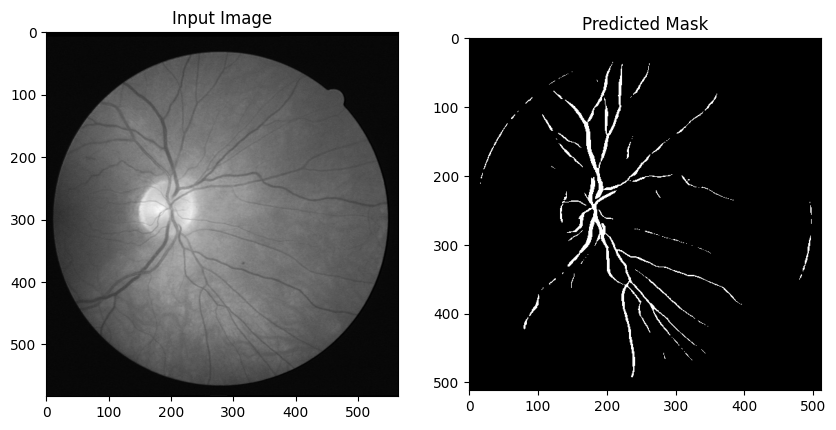

In [13]:
import torch
from torchvision import transforms
from PIL import Image

model.eval()


transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])


input_image = Image.open('15_test.tif').convert('L')  
input_tensor = transform(input_image).unsqueeze(0) 


with torch.no_grad():
    output = model(input_tensor.cuda())


predicted_mask = (output > 0.5).float()


import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image,cmap='gray')
plt.title('Input Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_mask.squeeze().cpu().numpy(), cmap='gray')
plt.title('Predicted Mask')

plt.show()

In [14]:
torch.save(model.state_dict(),"AttentionCNN-latest.pth")